In [5]:
import torch
import transformers
import supervision
import pytorch_lightning
import os 
import torchvision
import random 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
from transformers import DetrImageProcessor

In [54]:
print(supervision.__version__)
print(torch.__version__)
print(transformers.__version__)
print(pytorch_lightning.__version__)
print(torchvision.__version__)
print(cv2.__version__)


0.3.0
2.3.1+cpu
4.42.4
2.3.3
0.18.1+cpu
4.10.0


In [6]:
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [13]:
dataset = r'D:\Data Science\DocScan-Research\output\coco files'
ANNOTATION_FILE_NAME = 'result.json'

train_directory = os.path.join(dataset, r'set1\images')
val_directory = os.path.join(dataset, r'set2\images')
test_directory = os.path.join(dataset, r'set3\images')

In [14]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, image_directory_path: str, image_processor, train: bool = True):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        # Check if the annotation file exists
        if not os.path.exists(annotation_file_path):
            raise FileNotFoundError(f"Annotation file '{ANNOTATION_FILE_NAME}' not found in '{image_directory_path}'")
        
        # Call the superclass constructor with the image directory and annotation file path
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # Call the superclass __getitem__ to get images and annotations
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        
        # Retrieve image_id and construct annotations dictionary
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        
        # Use image_processor to encode images and annotations
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]  # Assuming single label for simplicity

        return pixel_values, target

# Create instances of your custom dataset for training, validation, and testing
try:
    TRAIN_DATASET = CocoDetection(image_directory_path=train_directory, image_processor=image_processor, train=True)
    VAL_DATASET = CocoDetection(image_directory_path=val_directory, image_processor=image_processor, train=False)
    TEST_DATASET = CocoDetection(image_directory_path=test_directory, image_processor=image_processor, train=False)

    # Print dataset sizes
    print("Number of training examples:", len(TRAIN_DATASET))
    print("Number of validation examples:", len(VAL_DATASET))
    print("Number of test examples:", len(TEST_DATASET))

except FileNotFoundError as e:
    print(f"Error occurred: {e}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 45
Number of validation examples: 46
Number of test examples: 46


Selected Image ID: 9
{'width': 792, 'height': 612, 'id': 9, 'file_name': '59a69b8f-image_page10.png'}


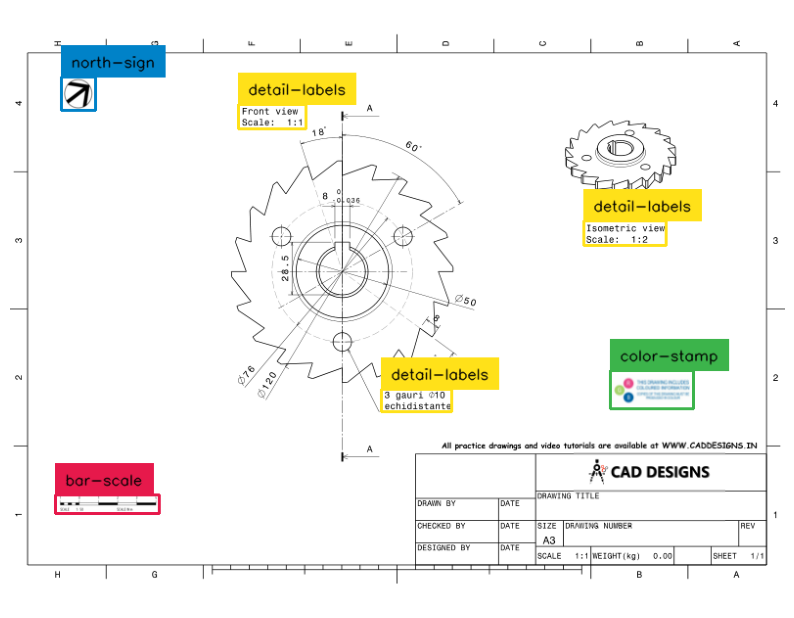

In [6]:
# Get a random image ID from the training dataset
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print("Selected Image ID:", image_id)

# Load the image and its annotations
image_info = TRAIN_DATASET.coco.loadImgs(image_id)[0]
print(image_info)

image_info['file_name'] = image_info['file_name'].replace("images\\" , "")
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image_info['file_name'])

image = cv2.imread(image_path)

# Continue with the detections and annotations
detections = supervision.Detections.from_coco_annotations(coco_annotation=annotations)
categories = TRAIN_DATASET.coco.cats

# Create a mapping from category IDs to labels
id2label = {category['id']: category['name'] for category in categories.values()}
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]

# Annotate the image with bounding boxes and labels
box_annotator = supervision.BoxAnnotator()
frame = box_annotator.annotate(image, detections, labels=labels)

# Display the annotated frame in Jupyter Notebook
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [37]:
from torch.utils.data import DataLoader
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    # print(pixel_values)
    encoding  = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return{
        'pixel_values' : encoding['pixel_values'],
        # 'pixel_mask' : encoding['attention_mask'],
        'pixel_mask' : encoding.get( 'attention_mask' ,None),
        'labels' : labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)   

In [26]:
CHECKPOINT = "facebook/detr-resnet-50"
class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT, 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        # pixel_mask = batch["pixel_mask"]
        pixel_mask = batch.get("pixel_mask", None)
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER


In [27]:
# model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

# batch = next(iter(TRAIN_DATALOADER))
# outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [28]:
from pytorch_lightning import Trainer
MAX_EPOCHS = 10
trainer  = Trainer(max_epochs=MAX_EPOCHS,gradient_clip_val=0.1,accumulate_grad_batches=2,log_every_n_steps=2)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: d:\Data Science\DocScan-Research\notebooks\lightning_logs

  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.010   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\Data Science\DocScan-Research\envdocscan\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:13<00:13,  0.07it/s]

d:\Data Science\DocScan-Research\envdocscan\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


d:\Data Science\DocScan-Research\envdocscan\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 12/12 [08:58<00:00,  0.02it/s, v_num=0]

d:\Data Science\DocScan-Research\envdocscan\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 9: 100%|██████████| 12/12 [06:34<00:00,  0.03it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 12/12 [06:37<00:00,  0.03it/s, v_num=0]


In [30]:
model.model.save_pretrained(MODEL_PATH)

In [11]:
MODEL_PATH = 'D:\Data Science\DocScan-Research'
model_path = r'D:\Data Science\DocScan-Research\model.safetensors'
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at D:\Data Science\DocScan-Research and are newly initialized: ['bbox_predictor.layers.0.bias', 'bbox_predictor.layers.0.weight', 'bbox_predictor.layers.1.bias', 'bbox_predictor.layers.1.weight', 'bbox_predictor.layers.2.bias', 'bbox_predictor.layers.2.weight', 'class_labels_classifier.bias', 'class_labels_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:

CONFIDENCE_THRESHOLD = 0.7
categories = TEST_DATASET.coco.cats
id2label = {category['id']: category['name'] for category in categories.values()}
box_annotator = supervision.BoxAnnotator()
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print("Selected Image ID:", image_id)


image  = TEST_DATASET.coco.loadImgs(image_id)[0] 
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)


detections = supervision.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame_ground_truth = box_annotator.annotate(image, detections, labels=labels)

with torch.no_grad():
     inputs = image_processor(images=image, return_tensors="pt")
     outputs = model(**inputs)
     
     target_size = torch.tensor([image.shape[:2]])
     results = image_processor.post_process_object_detection(
          outputs, 
          threshold=CONFIDENCE_THRESHOLD,
          target_sizes=target_size)[0]
     
     detections = supervision.Detections.from_transformers(transformers_results=results)
     labels = [f"{id2label[class_id]}" for _, confidence, class_id, _ in detections]
     frame_detection = box_annotator.annotate(scene=image.copy() ,detections=detections, labels=labels)
     

Selected Image ID: 35


Text(0.5, 1.0, 'Detection')

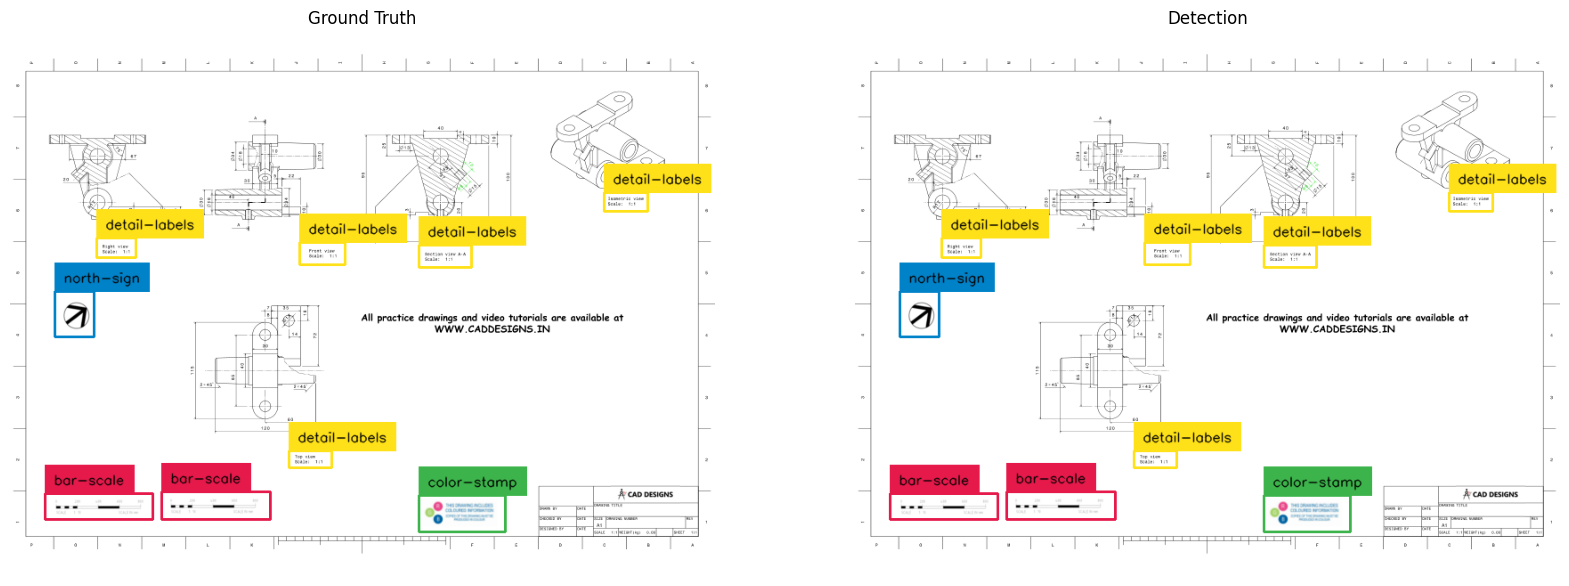

In [51]:
fig , axs = plt.subplots(1,2,figsize=(20,10))
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title("Ground Truth")


axs[1].imshow(cv2.cvtColor(frame_detection, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title("Detection")
